In [ ]:
# 4) # TO RUN, SIMPLY RUN ALL

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [3]:
full_data = pd.read_csv('final_df_with_emotions.csv')
sentiment_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
top_genres = full_data['genre'].value_counts().nlargest(10).index

# filter for songs in the top genres and valid popularity scores
filtered_df = full_data[
    (full_data['genre'].isin(top_genres)) &
    (full_data['popularity'] > 0) &
    (full_data['popularity'].notna())
]

# split into train, test, tune
unique_songs = filtered_df['song_artist'].unique()
songs_train_tune, songs_test = train_test_split(
    unique_songs, test_size=0.2, random_state=42
)
tune_ratio = 0.1 / (1 - 0.2)  # Adjust tune size relative to the remaining data
songs_train, songs_tune = train_test_split(
    songs_train_tune, test_size=tune_ratio, random_state=42
)

train_df = filtered_df[filtered_df['song_artist'].isin(songs_train)]
tune_df = filtered_df[filtered_df['song_artist'].isin(songs_tune)]
test_df = filtered_df[filtered_df['song_artist'].isin(songs_test)]

# ensure all songs have valid data (20x7)
def validate_data(df):
    valid_songs = (
        df.groupby('song_artist')
        .filter(lambda x: len(x) == 20)['song_artist']
        .unique()
    )
    return df[df['song_artist'].isin(valid_songs)]

train_df = validate_data(train_df)
tune_df = validate_data(tune_df)
test_df = validate_data(test_df)

print(f"Train set: {len(train_df)} rows, {train_df['song_artist'].nunique()} unique songs")
print(f"Tune set: {len(tune_df)} rows, {tune_df['song_artist'].nunique()} unique songs")
print(f"Test set: {len(test_df)} rows, {test_df['song_artist'].nunique()} unique songs")


Train set: 95060 rows, 4753 unique songs
Tune set: 13600 rows, 680 unique songs
Test set: 27180 rows, 1359 unique songs


In [4]:
train_df

,song_artist,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,...,stride,window_index,window_text,anger,disgust,fear,joy,neutral,sadness,surprise
360,anna sun - walk the moon,61,2012,alt-rock,0.472,0.844,10,-6.578,1,0.0540,...,20,0,screen falling off the door door hanging off t...,0.038343,0.014882,0.018864,0.005592,0.086255,0.783576,0.052488
361,anna sun - walk the moon,61,2012,alt-rock,0.472,0.844,10,-6.578,1,0.0540,...,20,1,fringes we tore up the walls we slept on couch...,0.833283,0.022907,0.058656,0.002851,0.039539,0.014575,0.028188
362,anna sun - walk the moon,61,2012,alt-rock,0.472,0.844,10,-6.578,1,0.0540,...,20,2,the east my car parked south your hands on my ...,0.403547,0.151907,0.099213,0.016981,0.198571,0.086270,0.043511
363,anna sun - walk the moon,61,2012,alt-rock,0.472,0.844,10,-6.578,1,0.0540,...,20,3,the wall on the west mezzanine we rattle this ...,0.545919,0.055544,0.080076,0.011758,0.215630,0.052453,0.038619
364,anna sun - walk the moon,61,2012,alt-rock,0.472,0.844,10,-6.578,1,0.0540,...,20,4,what do you know? this house is falling apart ...,0.051798,0.009747,0.018578,0.003834,0.017812,0.029777,0.868455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211855,recently - jim croce,12,2011,singer-songwriter,0.690,0.214,0,-17.495,1,0.0537,...,8,15,doesn't matter now who was wrong the future is,0.301191,0.063810,0.007405,0.004125,0.597054,0.017089,0.009325
211856,recently - jim croce,12,2011,singer-songwriter,0.690,0.214,0,-17.495,1,0.0537,...,8,16,tomorrow 'cause the past is gone and i'm,0.004772,0.006103,0.018585,0.004189,0.043673,0.916892,0.005787
211857,recently - jim croce,12,2011,singer-songwriter,0.690,0.214,0,-17.495,1,0.0537,...,8,17,findin' that i'm not as strong as i thought,0.010412,0.016579,0.293162,0.020691,0.045054,0.389997,0.224106
211858,recently - jim croce,12,2011,singer-songwriter,0.690,0.214,0,-17.495,1,0.0537,...,8,18,that i used to be 'cause recently it,0.034753,0.017376,0.028584,0.039856,0.353018,0.131015,0.395397


In [5]:
# preprocessing step
# modify data to include only relevant columns
def preprocess_emotion_data(df):
    valid_songs = df.groupby('song_artist').filter(lambda x: len(x) == 20)
    metadata = valid_songs.drop_duplicates(subset='song_artist')[['song_artist', 'genre', 'popularity']].reset_index(drop=True)

    # flatten sentiment columns for each song
    def flatten_song_emotions(song_df):
        return song_df.sort_values('window_index')[sentiment_columns].values.flatten()
    flattened_emotions = valid_songs.groupby('song_artist', group_keys=False).apply(flatten_song_emotions)
    flattened_emotions_list = [row for row in flattened_emotions]
    feature_columns = [f"{emotion}_{i}" for i in range(20) for emotion in sentiment_columns]
    flattened_emotions_df = pd.DataFrame(flattened_emotions_list, columns=feature_columns)

    # concatenate metadata and flattened emotion features
    final_df = pd.concat([metadata, flattened_emotions_df], axis=1)

    return final_df

In [6]:
train_flattened = preprocess_emotion_data(train_df)
tune_flattened = preprocess_emotion_data(tune_df)
test_flattened = preprocess_emotion_data(test_df)


/var/folders/56/ntwrbpx9491dpp44ysgs9q380000gn/T/ipykernel_82652/2215405740.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  flattened_emotions = valid_songs.groupby('song_artist', group_keys=False).apply(flatten_song_emotions)
/var/folders/56/ntwrbpx9491dpp44ysgs9q380000gn/T/ipykernel_82652/2215405740.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  flattened_emotions = valid_songs.groupby('song_ar

In [7]:
emotion_columns = [f"{emotion}_{i}" for emotion in ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'] for i in range(20)]


In [8]:
# advanced models
# hyperparameter tuning configurations
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'SVR': {
        'C': [0.1, 1.0, 10],
        'kernel': ['rbf', 'linear'],
        'epsilon': [0.01, 0.1, 0.5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    },
    'Ridge': {
        'alpha': [0.1, 1.0, 10]
    },
    'Lasso': {
        'alpha': [0.01, 0.1, 1.0]
    }
}

# function to perform hyperparameter tuning and training
def tune_and_train_model(model_name, base_estimator, param_grid, X_train, y_train, X_tune, y_tune):
    X_combined = np.vstack((X_train, X_tune))
    y_combined = np.hstack((y_train, y_tune))
    
    grid_search = GridSearchCV(
        estimator=base_estimator,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1
    )
    
    grid_search.fit(X_combined, y_combined)
    return grid_search.best_estimator_

# dictionary to store the tuned models for each regression type
tuned_models = {
    'RandomForest': {},
    'SVR': {},
    'XGBoost': {},
    'Ridge': {},
    'Lasso': {}
}

# iterate over each genre and model type to perform tuning and training
for genre in train_flattened['genre'].unique():
    genre_train_data = train_flattened[train_flattened['genre'] == genre]
    genre_tune_data = tune_flattened[tune_flattened['genre'] == genre]

    X_train_genre = genre_train_data[emotion_columns].values
    y_train_genre = genre_train_data['popularity'].values

    X_tune_genre = genre_tune_data[emotion_columns].values
    y_tune_genre = genre_tune_data['popularity'].values

    # Random Forest
    rf_best = tune_and_train_model(
        'RandomForest',
        RandomForestRegressor(random_state=42),
        param_grids['RandomForest'],
        X_train_genre,
        y_train_genre,
        X_tune_genre,
        y_tune_genre
    )
    tuned_models['RandomForest'][genre] = rf_best

    # SVR
    svr_best = tune_and_train_model(
        'SVR',
        SVR(),
        param_grids['SVR'],
        X_train_genre,
        y_train_genre,
        X_tune_genre,
        y_tune_genre
    )
    tuned_models['SVR'][genre] = svr_best

    # XGBoost
    xgb_best = tune_and_train_model(
        'XGBoost',
        XGBRegressor(objective='reg:squarederror', random_state=42),
        param_grids['XGBoost'],
        X_train_genre,
        y_train_genre,
        X_tune_genre,
        y_tune_genre
    )
    tuned_models['XGBoost'][genre] = xgb_best

    # Ridge Regression
    ridge_best = tune_and_train_model(
        'Ridge',
        Ridge(),
        param_grids['Ridge'],
        X_train_genre,
        y_train_genre,
        X_tune_genre,
        y_tune_genre
    )
    tuned_models['Ridge'][genre] = ridge_best

    # Lasso Regression
    lasso_best = tune_and_train_model(
        'Lasso',
        Lasso(),
        param_grids['Lasso'],
        X_train_genre,
        y_train_genre,
        X_tune_genre,
        y_tune_genre
    )
    tuned_models['Lasso'][genre] = lasso_best

# evaluate models
def evaluate_models(test_data, emotion_columns, tuned_models):
    results = {}
    for model_name in tuned_models.keys():
        predicted_popularity = []
        actual_popularity = []
        song_titles = []
        
        for _, row in test_data.iterrows():
            genre = row['genre']
            if genre in tuned_models[model_name]:
                model = tuned_models[model_name][genre]
                X_test = row[emotion_columns].values.reshape(1, -1)
                predicted_popularity.append(model.predict(X_test)[0])
                actual_popularity.append(row['popularity'])
                song_titles.append(row['song_artist'])

        # calculate evaluation metrics
        mse = mean_squared_error(actual_popularity, predicted_popularity)
        mae = mean_absolute_error(actual_popularity, predicted_popularity)
        r2 = r2_score(actual_popularity, predicted_popularity)

        results[model_name] = {
            'MSE': mse,
            'MAE': mae,
            'R2': r2,
            'Predictions': pd.DataFrame({
                'Song Title': song_titles,
                'Actual Popularity': actual_popularity,
                'Predicted Popularity': predicted_popularity
            })
        }

        print(f"\n{model_name} Test Set Metrics:")
        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"R-squared (R²): {r2}")

    return results

test_results = evaluate_models(test_flattened, emotion_columns, tuned_models)


/Users/rutvashah/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/rutvashah/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/rutvashah/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



RandomForest Test Set Metrics:
Mean Squared Error (MSE): 132.30975937292882
Mean Absolute Error (MAE): 8.863914518533585
R-squared (R²): 0.4862164581818733

SVR Test Set Metrics:
Mean Squared Error (MSE): 132.2209683032133
Mean Absolute Error (MAE): 8.576547009061537
R-squared (R²): 0.48656125051235954

XGBoost Test Set Metrics:
Mean Squared Error (MSE): 129.61091915559635
Mean Absolute Error (MAE): 8.767827025575617
R-squared (R²): 0.49669655951554703

Ridge Test Set Metrics:
Mean Squared Error (MSE): 141.74249810914375
Mean Absolute Error (MAE): 9.16838162119164
R-squared (R²): 0.4495873694441521

Lasso Test Set Metrics:
Mean Squared Error (MSE): 126.94051773970104
Mean Absolute Error (MAE): 8.6629654975561
R-squared (R²): 0.5070662276642713


In [9]:
# function to extract and print best hyperparameters
def print_best_hyperparameters(tuned_models):
    print("\nBest Hyperparameters for Each Model and Genre:")
    for model_name, genre_models in tuned_models.items():
        print(f"\nModel: {model_name}")
        for genre, best_model in genre_models.items():
            print(f"  Genre: {genre}")
            if hasattr(best_model, 'get_params'):
                # Print the best hyperparameters for the model
                best_params = best_model.get_params()
                print(f"    Best Hyperparameters: {best_params}")
            else:
                print("    No hyperparameters available to display.")

print_best_hyperparameters(tuned_models)


Best Hyperparameters for Each Model and Genre:

Model: RandomForest
  Genre: alt-rock
    Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
  Genre: blues
    Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
  Genre: country
    Best Hyperparameters: {'bootstrap

In [10]:
from sklearn.model_selection import GroupKFold
full_dataset = pd.concat([train_flattened, tune_flattened, test_flattened], ignore_index=True)

# initialize GroupKFold
n_splits = 5
group_kfold = GroupKFold(n_splits=n_splits)

# function to evaluate a fixed model with cross-validation
def cross_validate_fixed_model(model, X, y, groups):
    mse_scores = []
    mae_scores = []
    r2_scores = []

    # split data using GroupKFold
    for train_index, val_index in group_kfold.split(X, y, groups=groups):
        X_train_cv, X_val_cv = X[train_index], X[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]

        # train the model on the training split
        model.fit(X_train_cv, y_train_cv)

        # predict on the validation split
        y_pred = model.predict(X_val_cv)

        mse_scores.append(mean_squared_error(y_val_cv, y_pred))
        mae_scores.append(mean_absolute_error(y_val_cv, y_pred))
        r2_scores.append(r2_score(y_val_cv, y_pred))

    # compute average metrics
    avg_mse = np.mean(mse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)

    return avg_mse, avg_mae, avg_r2

cv_results = {}

for genre in full_dataset['genre'].unique():
    print(f"\nProcessing genre: {genre}")
    genre_data = full_dataset[full_dataset['genre'] == genre]
    X_genre = genre_data[emotion_columns].values
    y_genre = genre_data['popularity'].values
    groups_genre = genre_data['song_artist'].values  # Group by 'song_artist'

    cv_results[genre] = {}

    # evaluate models
    for model_name, genre_models in tuned_models.items():
        if genre in genre_models:
            best_model = genre_models[genre]  # The best model for this genre and type
            avg_mse, avg_mae, avg_r2 = cross_validate_fixed_model(
                best_model, X_genre, y_genre, groups_genre
            )
            cv_results[genre][model_name] = {
                'MSE': avg_mse,
                'MAE': avg_mae,
                'R2': avg_r2
            }
            print(f"{model_name} - MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}, R²: {avg_r2:.4f}")

# display results
for genre in cv_results:
    print(f"\nCross-Validation Results for Genre: {genre}")
    for model_name, metrics in cv_results[genre].items():
        print(f"{model_name} - MSE: {metrics['MSE']:.4f}, MAE: {metrics['MAE']:.4f}, R²: {metrics['R2']:.4f}")


Processing genre: alt-rock
RandomForest - MSE: 105.1977, MAE: 7.9903, R²: -0.0565
SVR - MSE: 104.1597, MAE: 7.6570, R²: -0.0442
XGBoost - MSE: 101.6714, MAE: 7.8654, R²: -0.0211
Ridge - MSE: 108.8931, MAE: 8.1483, R²: -0.0925
Lasso - MSE: 100.5747, MAE: 7.8286, R²: -0.0099

Processing genre: blues
RandomForest - MSE: 97.9722, MAE: 7.9285, R²: -0.0394
SVR - MSE: 99.6396, MAE: 7.6320, R²: -0.0490
XGBoost - MSE: 96.3590, MAE: 7.8306, R²: -0.0212
Ridge - MSE: 104.4455, MAE: 8.2002, R²: -0.1147
Lasso - MSE: 95.8098, MAE: 7.7753, R²: -0.0141

Processing genre: country
RandomForest - MSE: 145.1106, MAE: 9.5176, R²: -0.0257
SVR - MSE: 152.1399, MAE: 9.0498, R²: -0.0737
XGBoost - MSE: 142.9625, MAE: 9.4270, R²: -0.0087
Ridge - MSE: 156.1928, MAE: 9.8004, R²: -0.1028
Lasso - MSE: 141.8577, MAE: 9.3991, R²: -0.0005

Processing genre: dance
RandomForest - MSE: 200.0934, MAE: 11.2060, R²: -0.0080
SVR - MSE: 202.8292, MAE: 11.0838, R²: -0.0205
XGBoost - MSE: 199.5236, MAE: 11.1923, R²: -0.0042
Ridg

In [11]:
# ^well that's not good...


Residual Graphs for RandomForest


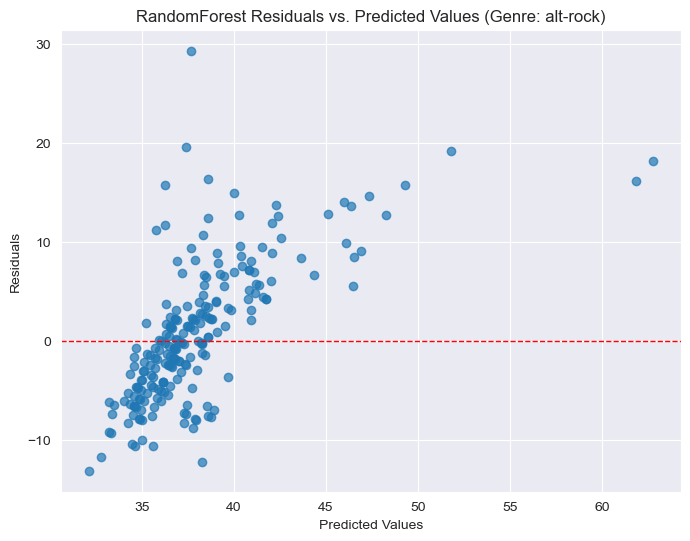

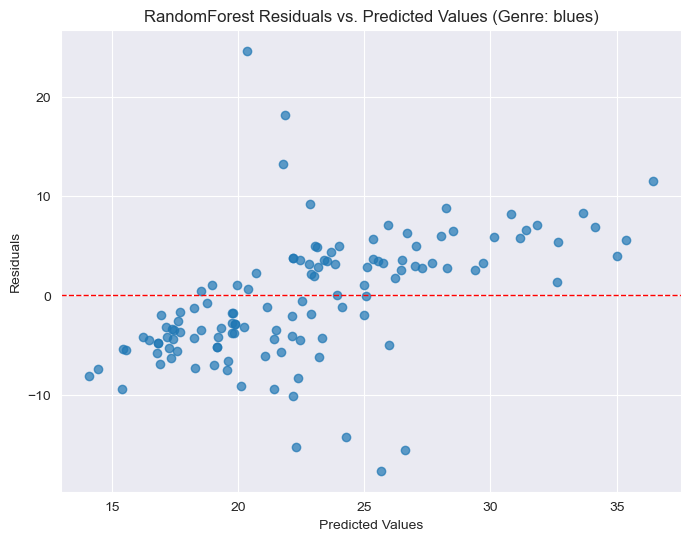

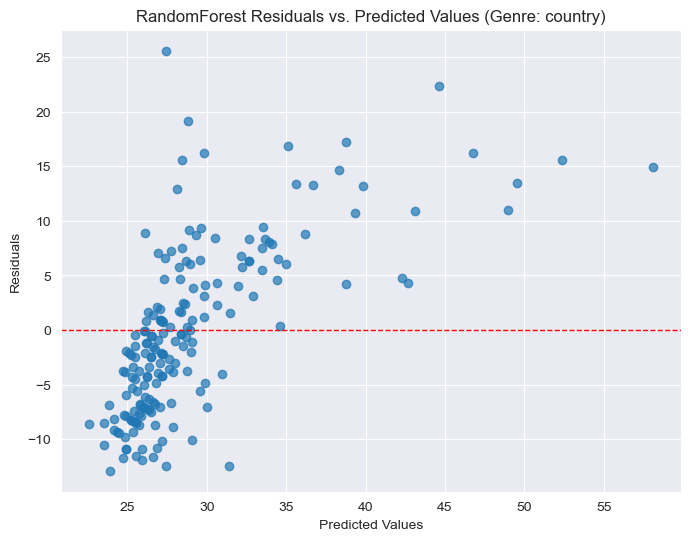

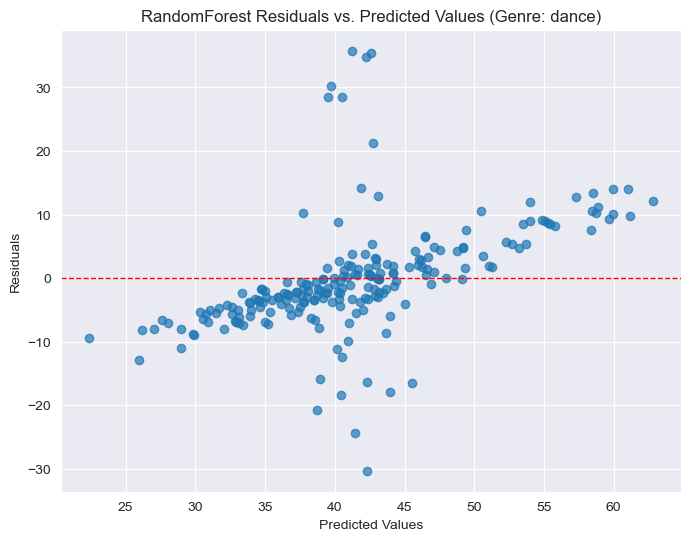

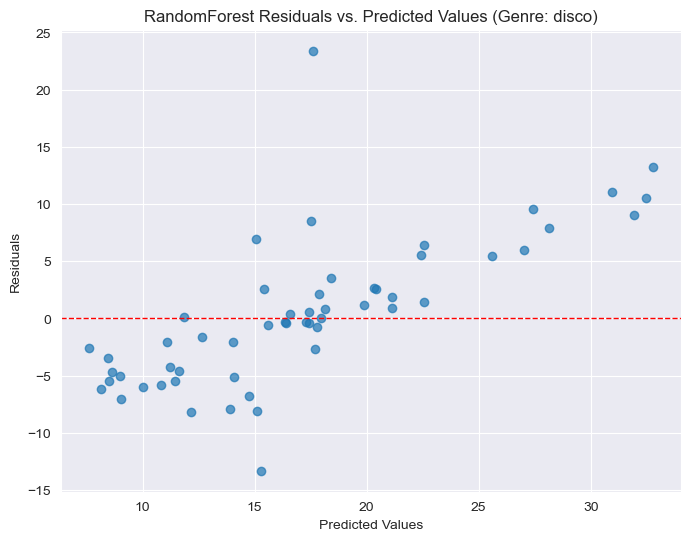

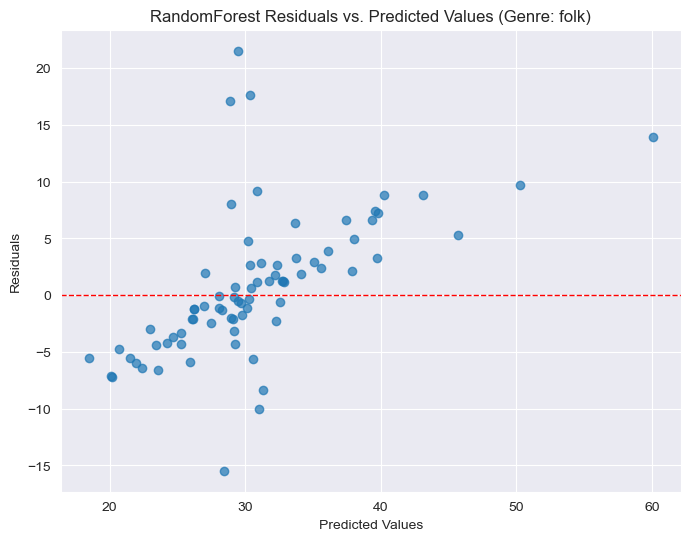

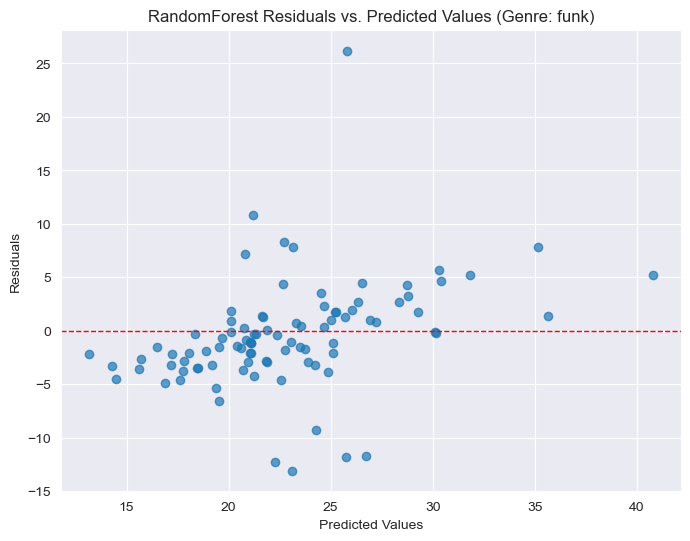

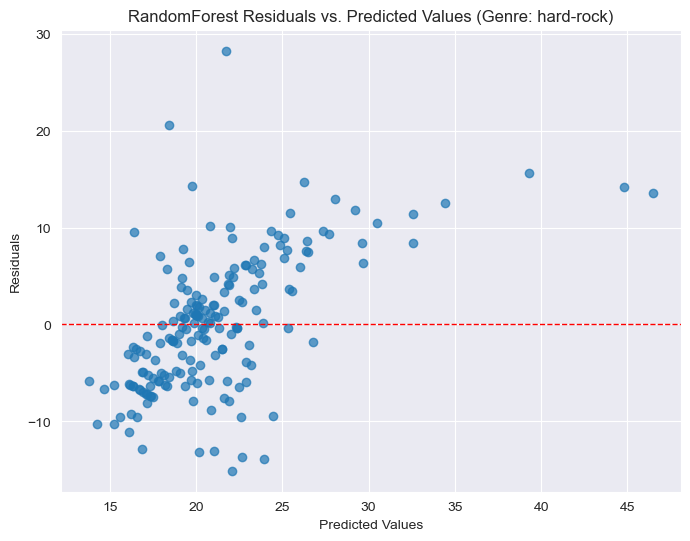

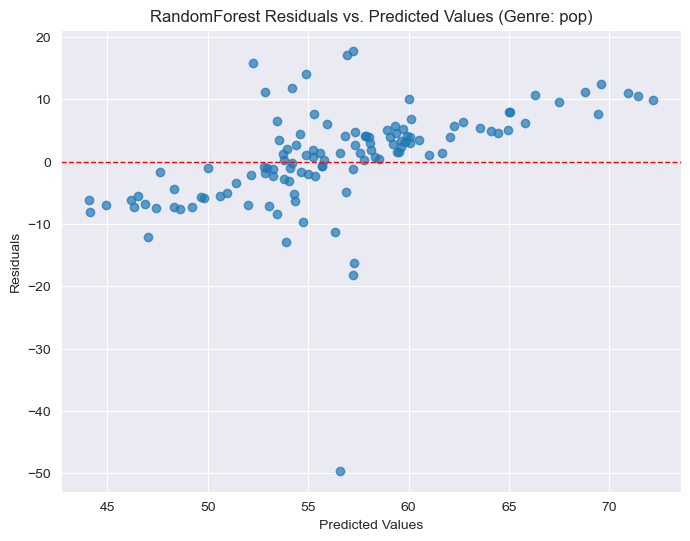

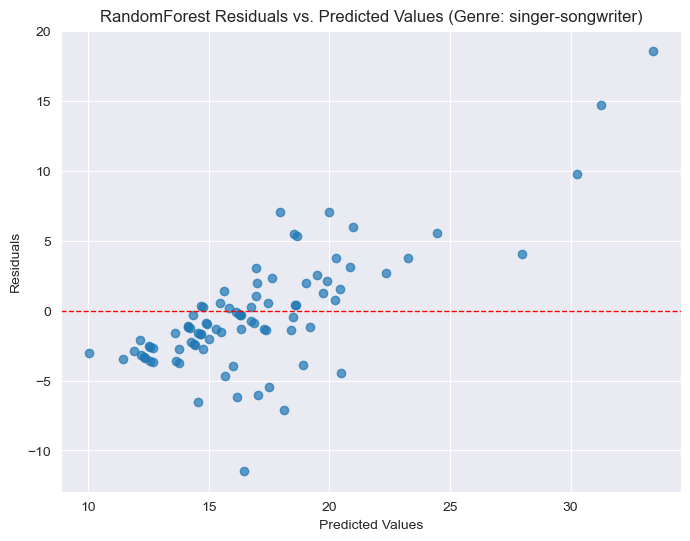


Residual Graphs for SVR


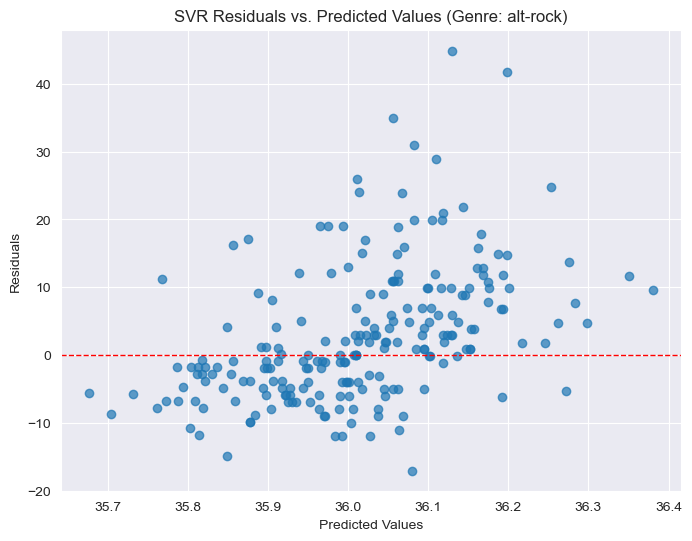

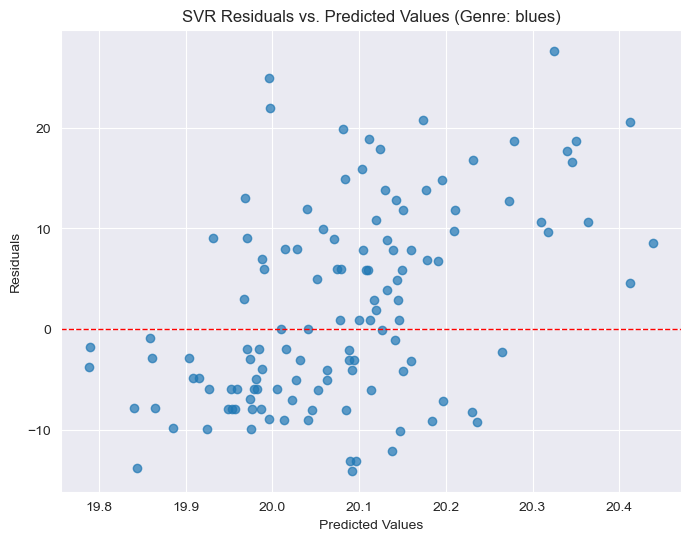

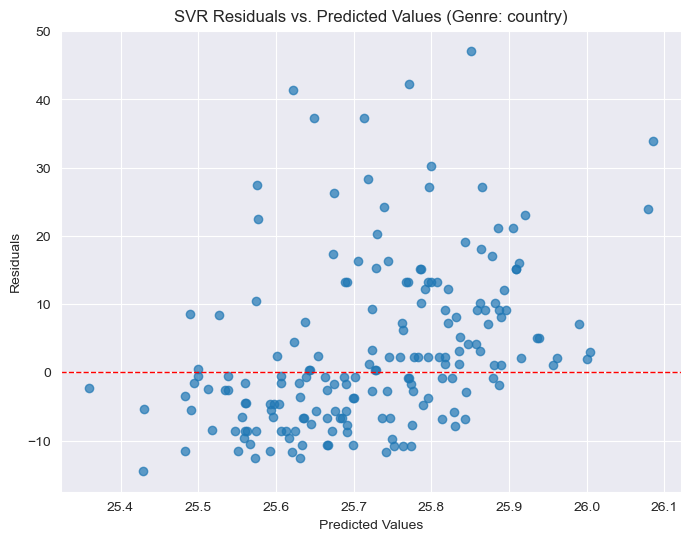

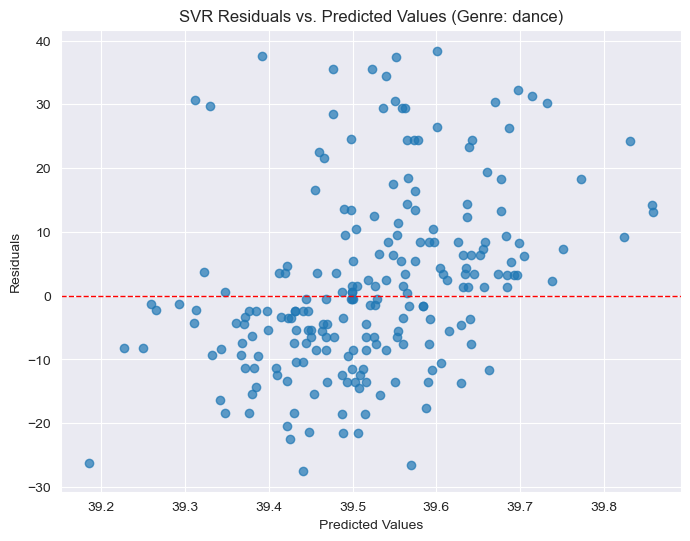

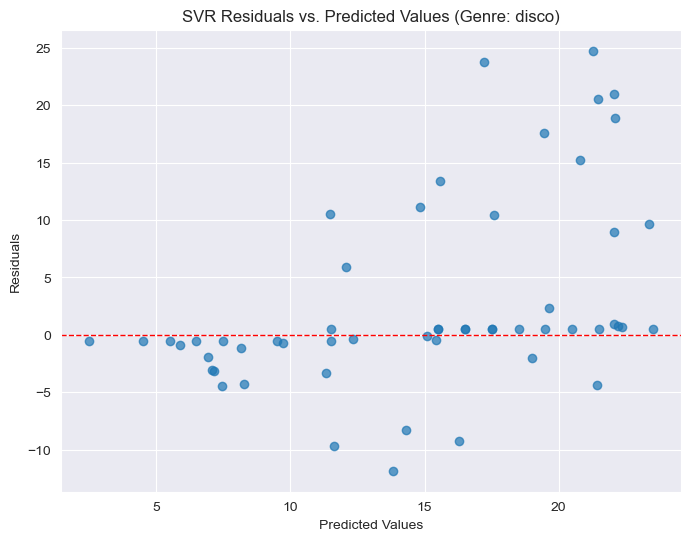

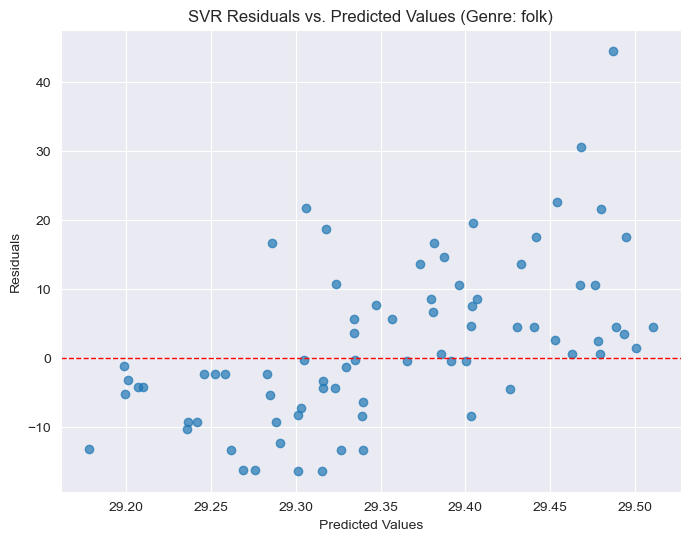

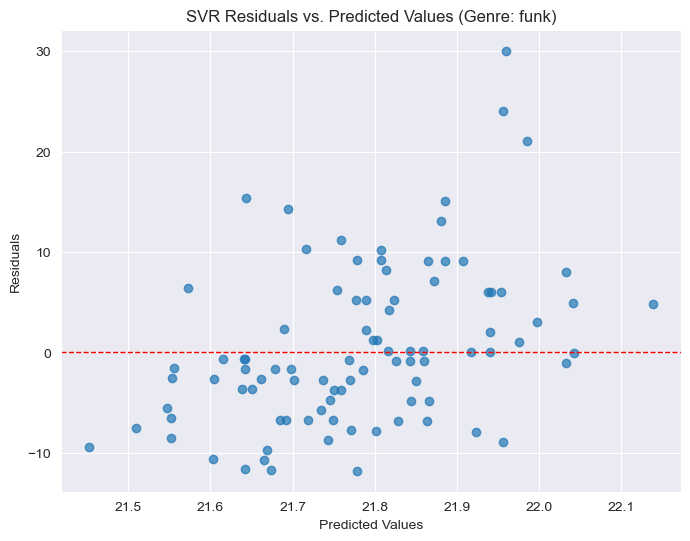

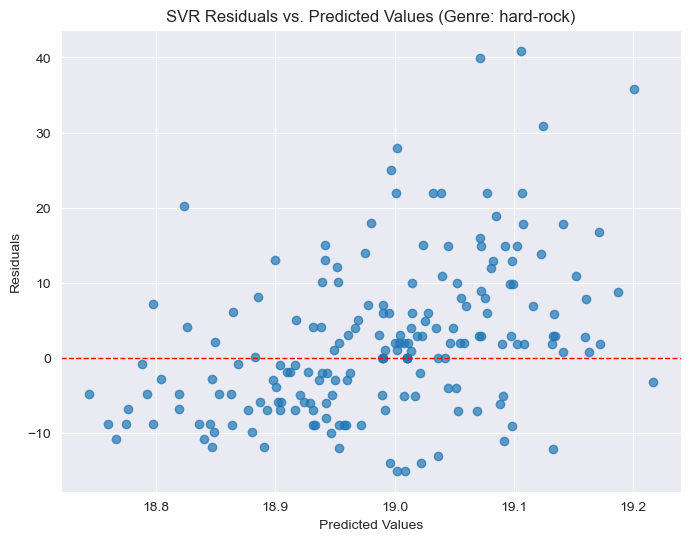

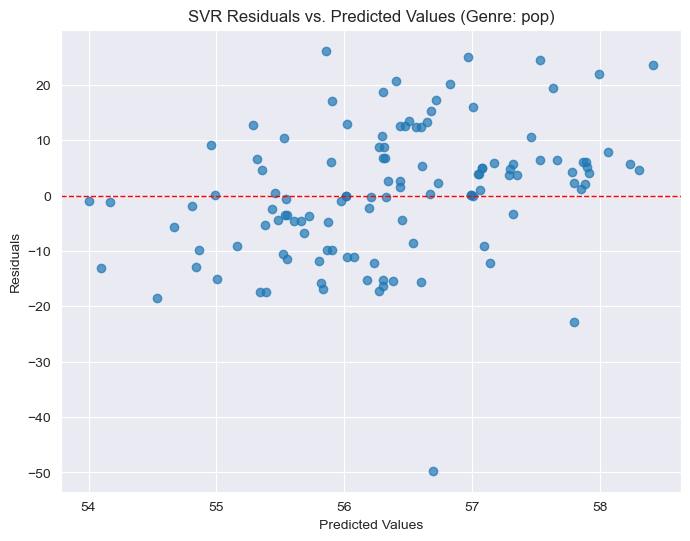

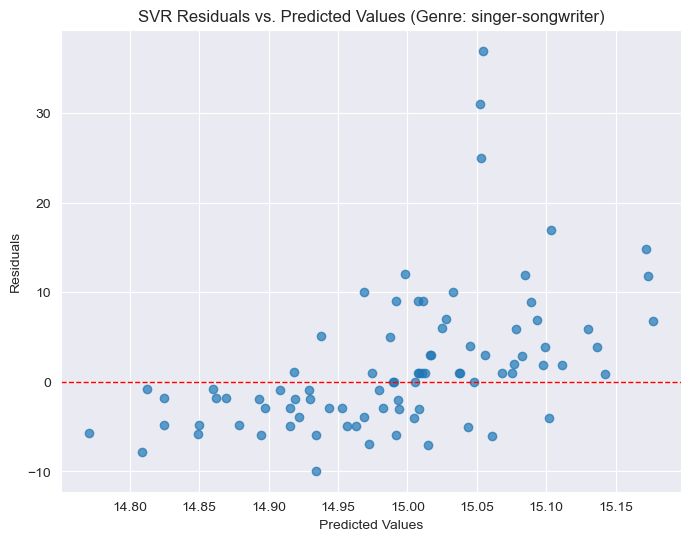


Residual Graphs for XGBoost


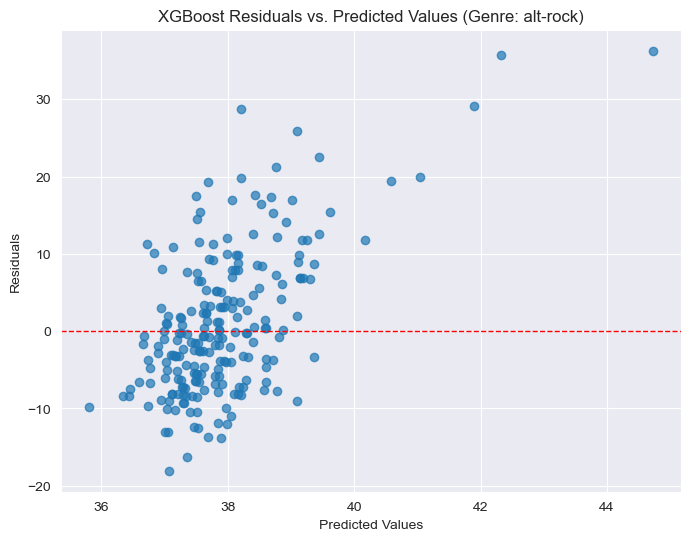

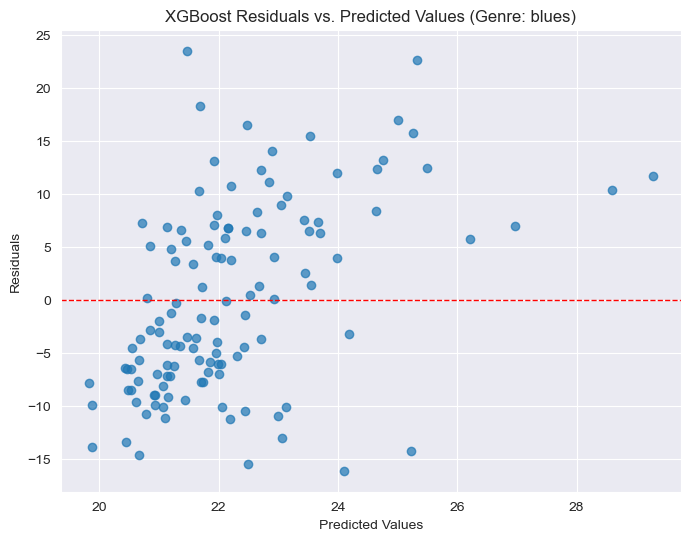

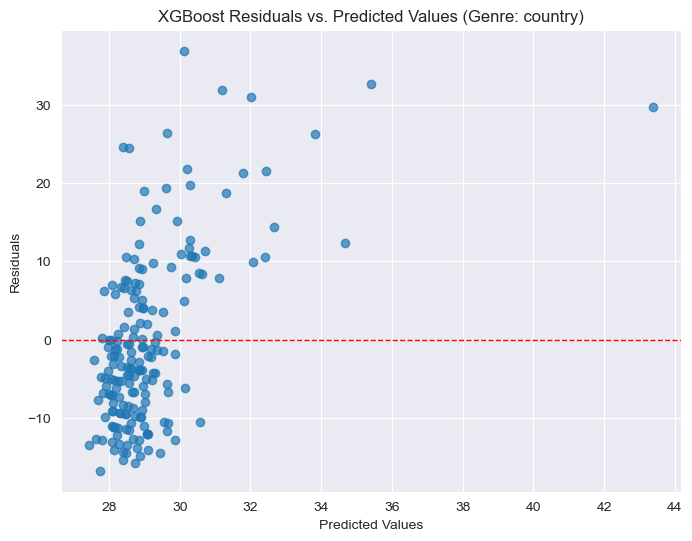

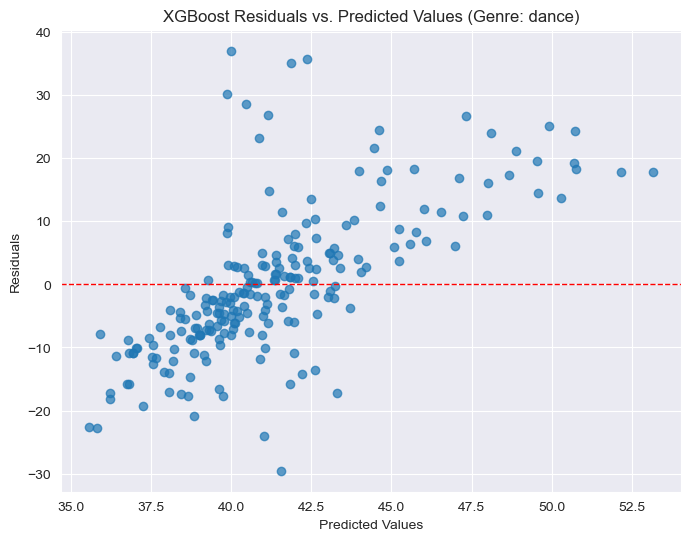

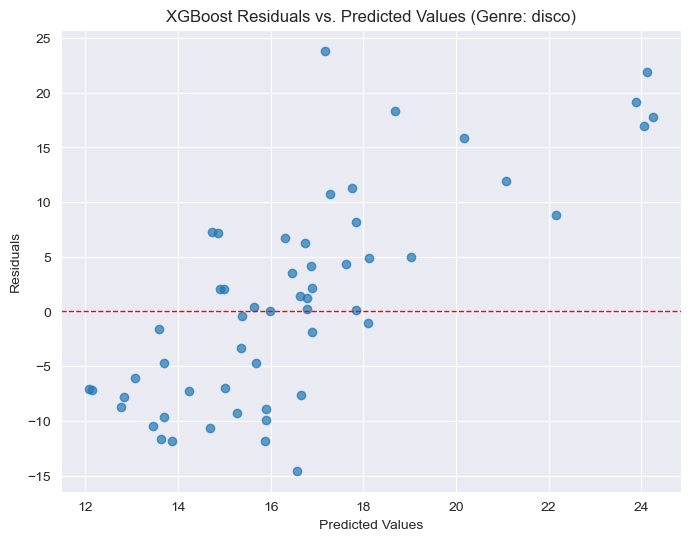

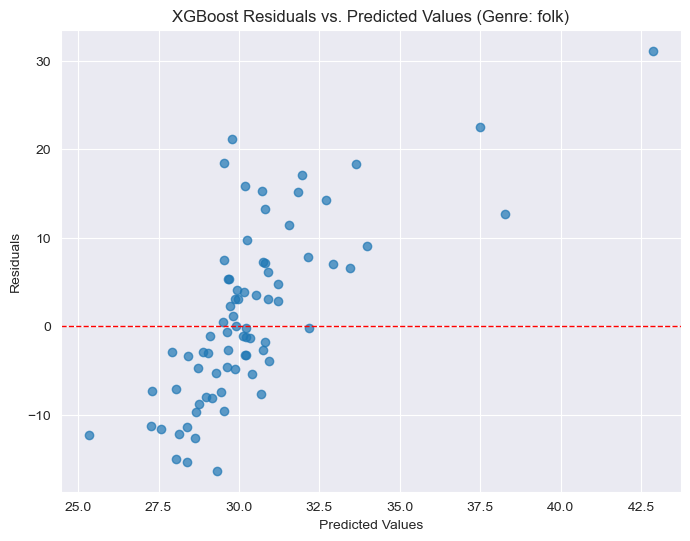

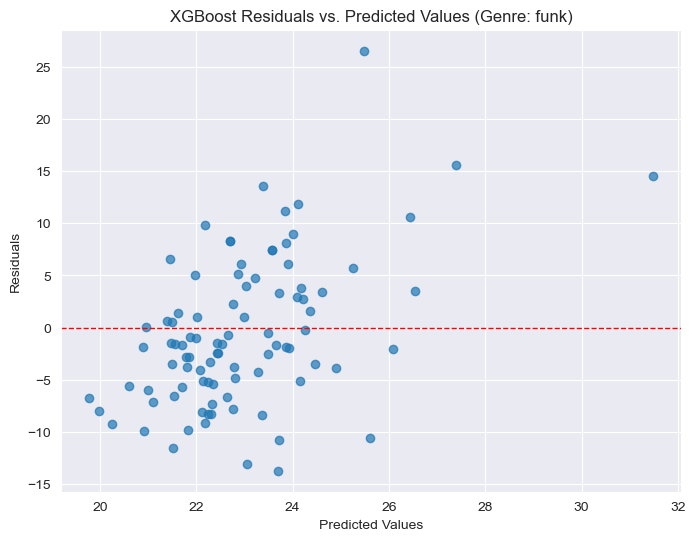

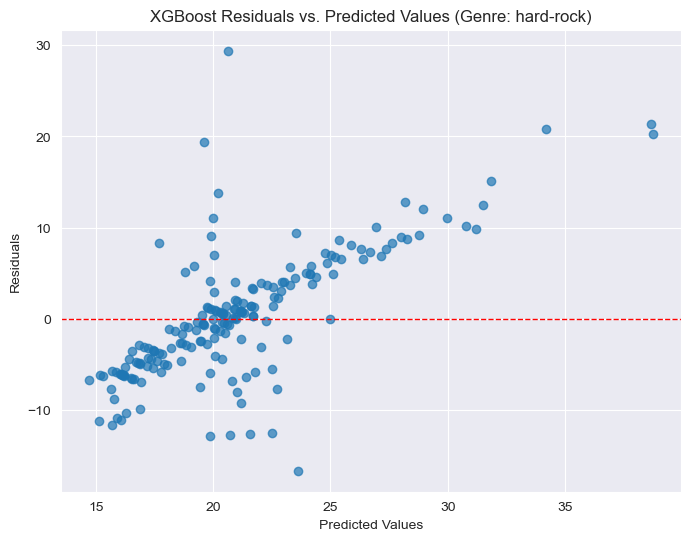

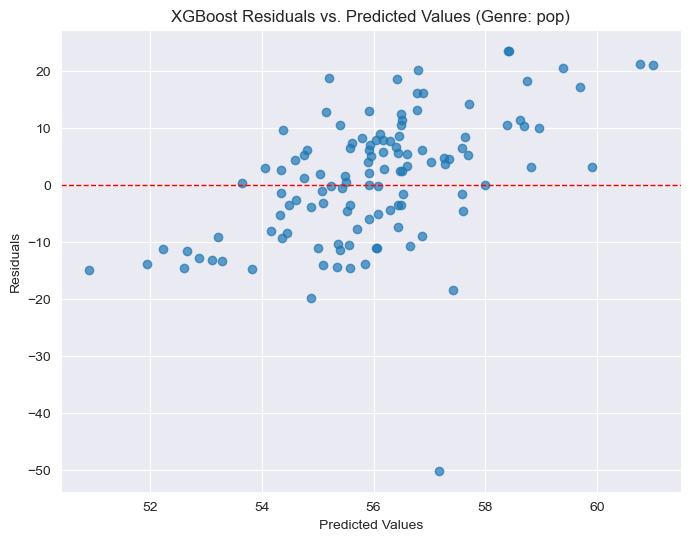

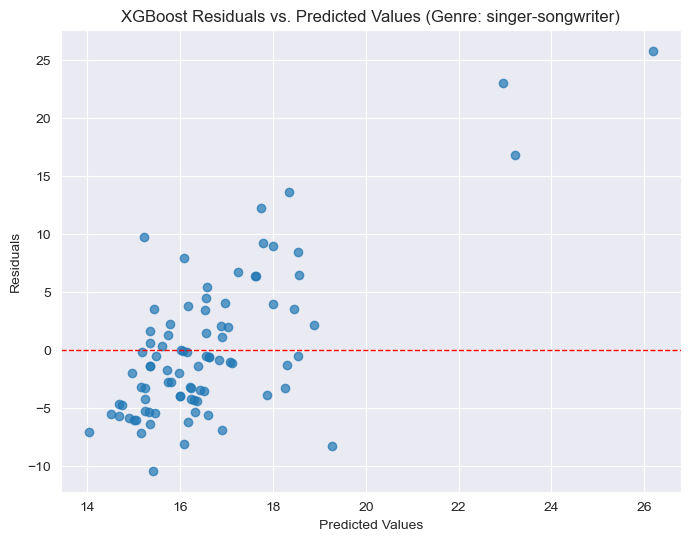


Residual Graphs for Ridge


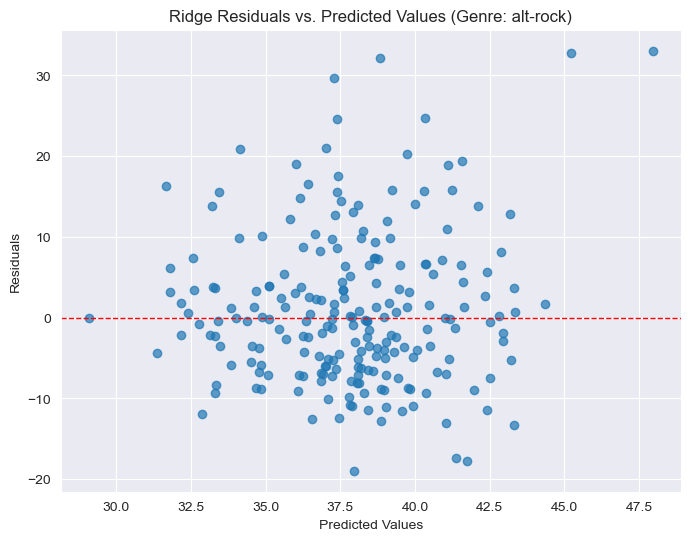

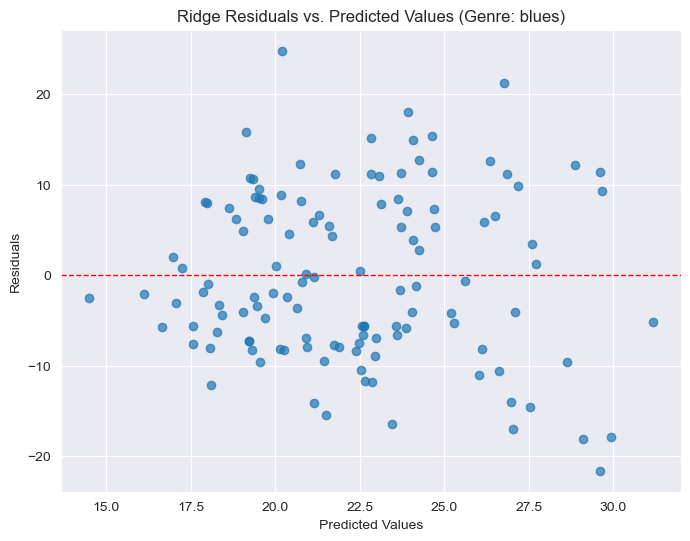

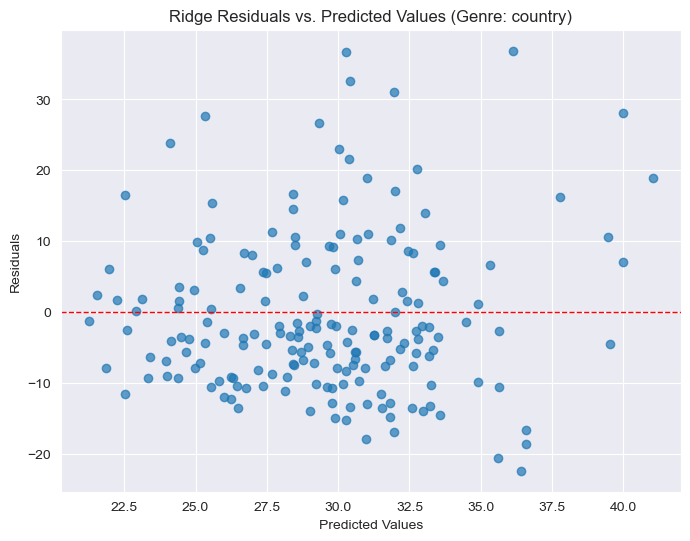

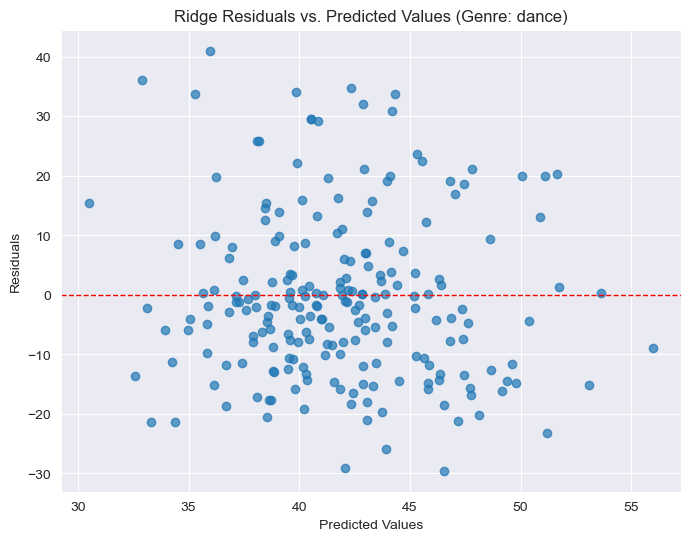

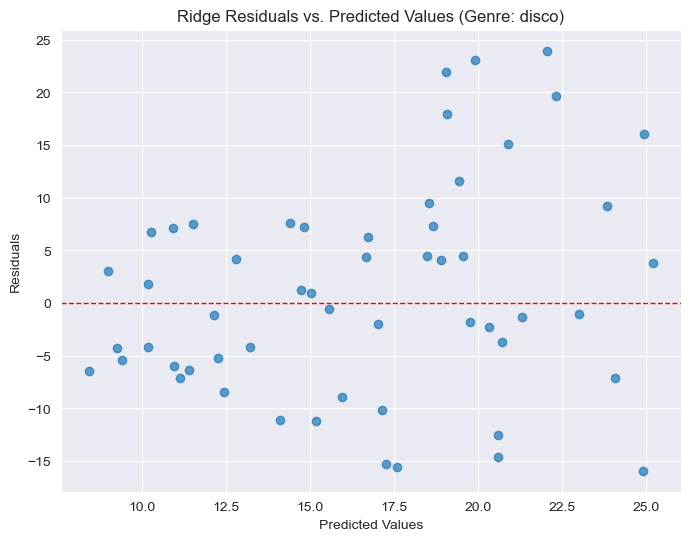

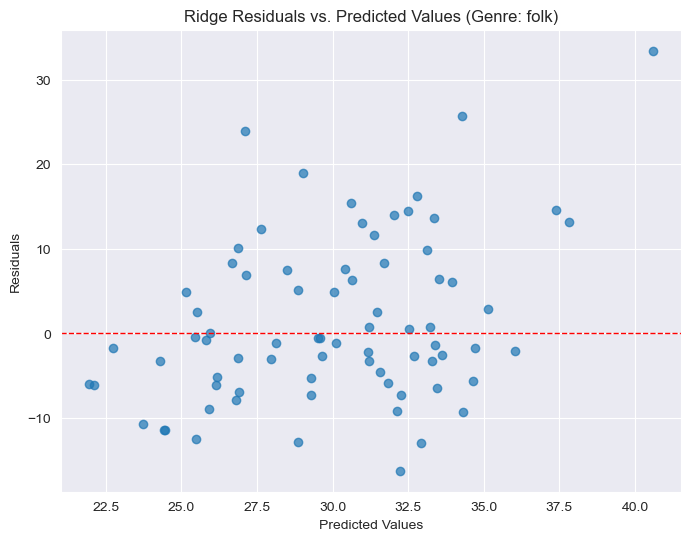

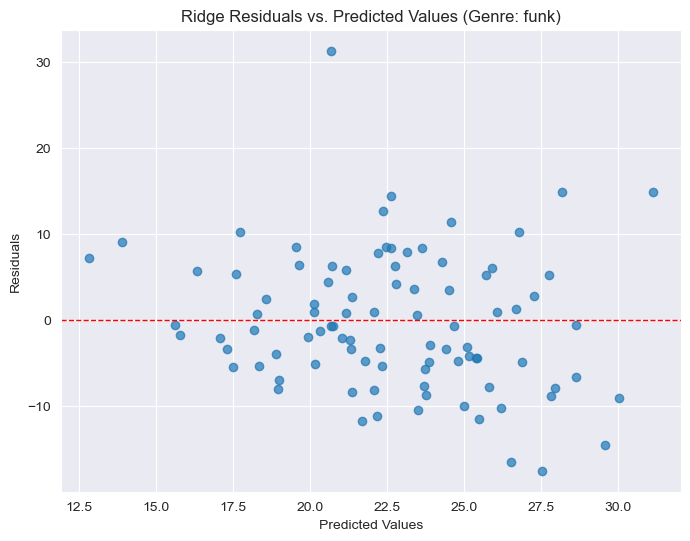

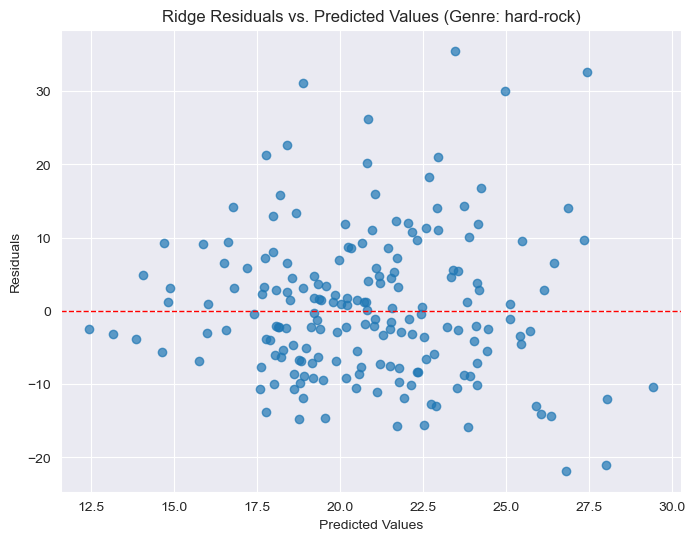

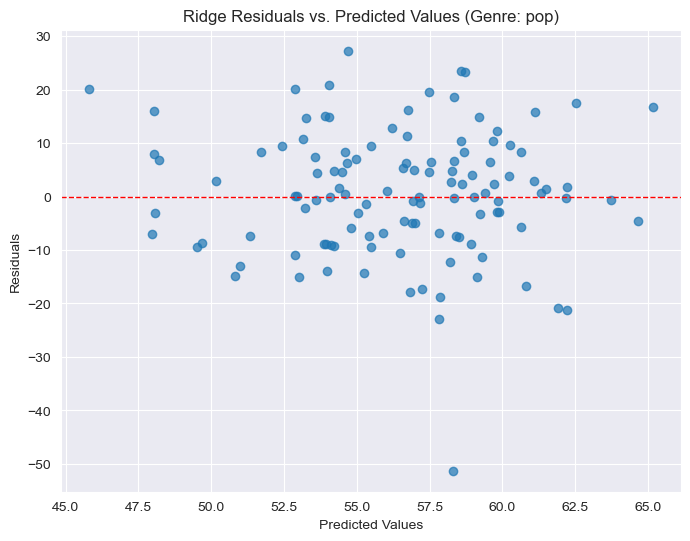

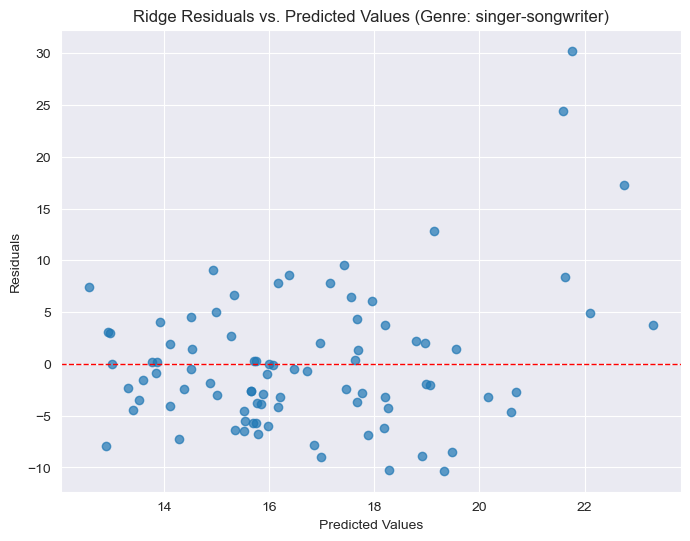


Residual Graphs for Lasso


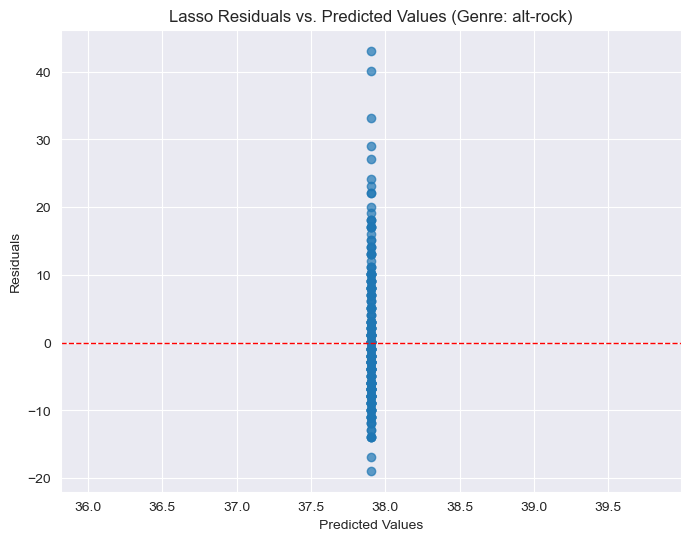

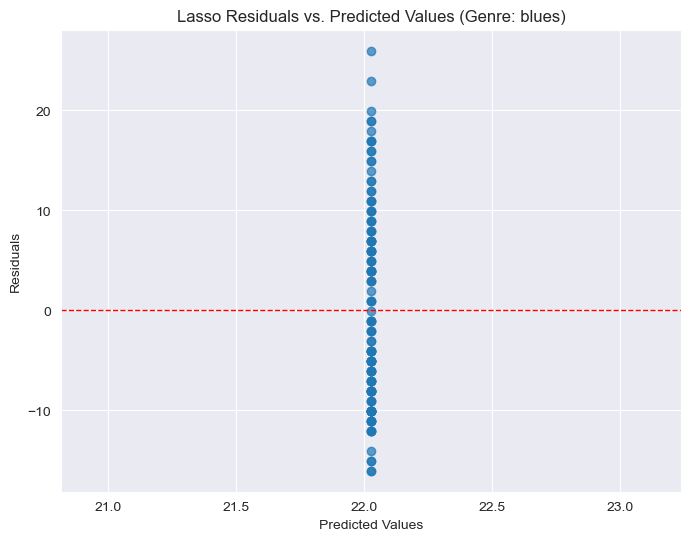

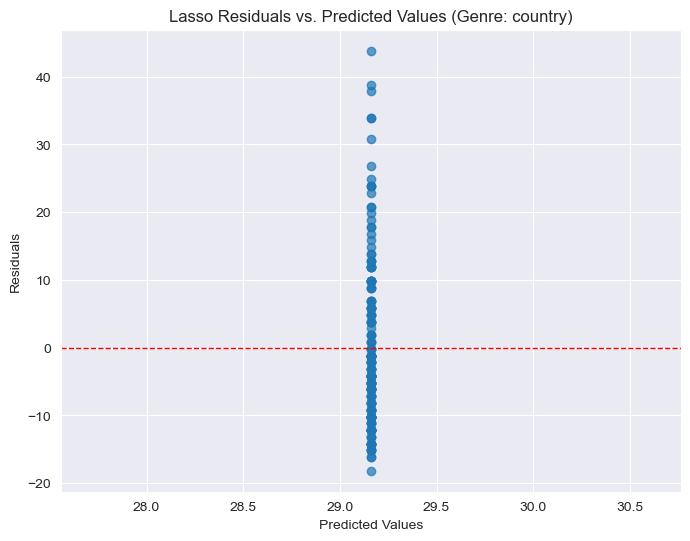

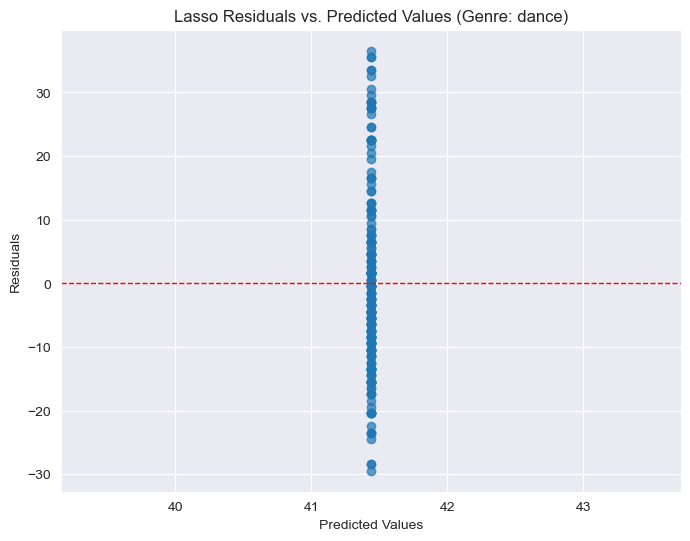

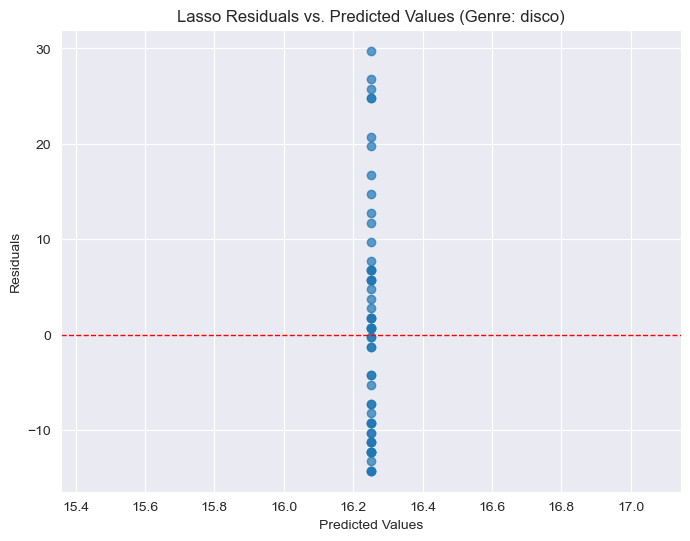

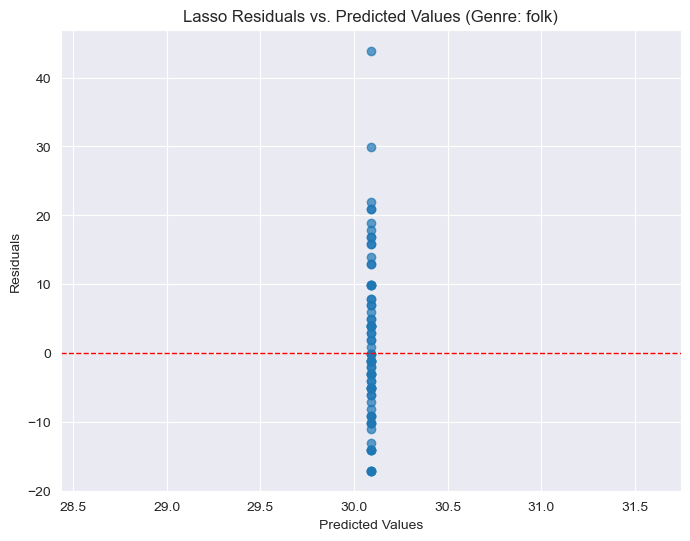

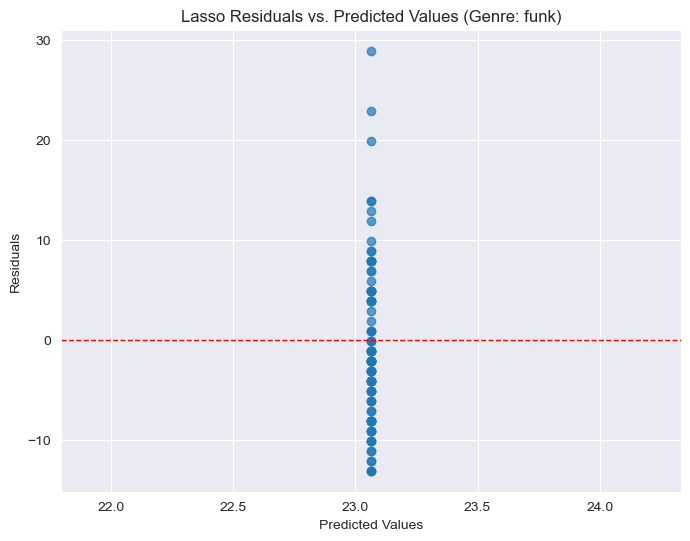

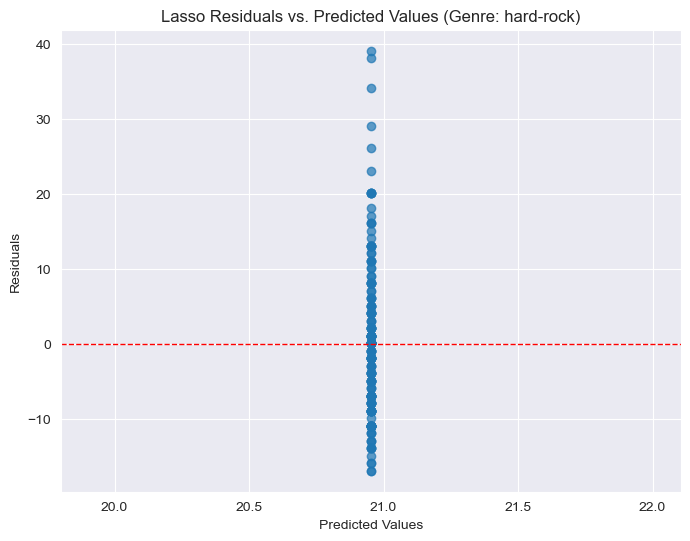

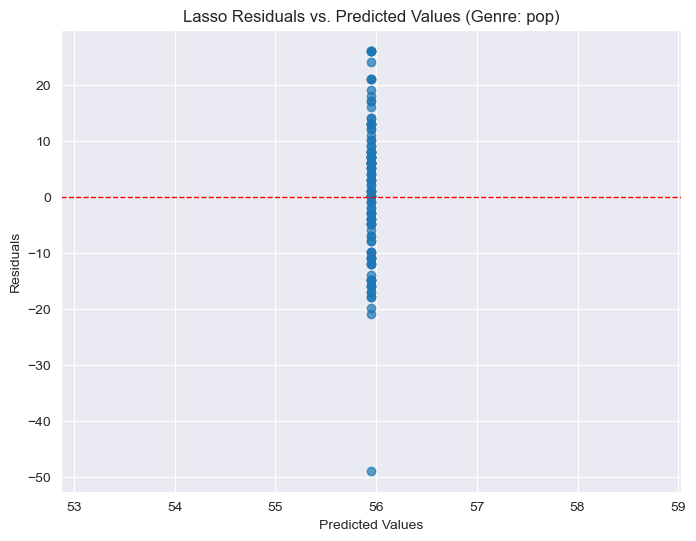

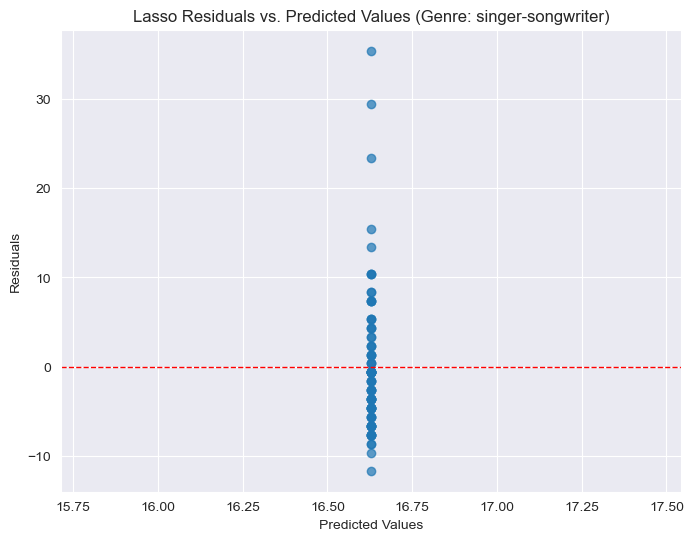

In [12]:
import matplotlib.pyplot as plt

# function to calculate residuals and plot residual graphs
def plot_residuals(model_name, genre, model, test_data, emotion_columns):
    genre_test_data = test_data[test_data['genre'] == genre]
    
    X_test = genre_test_data[emotion_columns].values
    y_test = genre_test_data['popularity'].values
    
    y_pred = model.predict(X_test)
    
    residuals = y_test - y_pred
    
    # plot residuals vs. predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
    plt.title(f"{model_name} Residuals vs. Predicted Values (Genre: {genre})")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

# iterate through the best models and genres to plot residuals
for model_name, genre_models in tuned_models.items():
    print(f"\nResidual Graphs for {model_name}")
    for genre, best_model in genre_models.items():
        plot_residuals(model_name, genre, best_model, test_flattened, emotion_columns)


In [13]:
# DTW Based Regression

from dtaidistance import dtw
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# select a single genre
genre = "pop"  # Replace with the genre of choice
genre_train_data = train_flattened[train_flattened['genre'] == genre]
genre_test_data = test_flattened[test_flattened['genre'] == genre]

# extract emotion data and popularity
X_train_genre = genre_train_data[emotion_columns].values
y_train_genre = genre_train_data['popularity'].values
X_test_genre = genre_test_data[emotion_columns].values
y_test_genre = genre_test_data['popularity'].values

# compute DTW Distance Matrix, calculate pairwise DTW distances for training data
dtw_distances_train = np.zeros((len(X_train_genre), len(X_train_genre)))
for i in range(len(X_train_genre)):
    for j in range(len(X_train_genre)):
        dtw_distances_train[i, j] = dtw.distance(X_train_genre[i], X_train_genre[j])

# train Random Forest Regressor on DTW distances
regressor_dtw = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
regressor_dtw.fit(dtw_distances_train, y_train_genre)

# compute DTW distances for test data
dtw_distances_test = np.zeros((len(X_test_genre), len(X_train_genre)))
for i in range(len(X_test_genre)):
    for j in range(len(X_train_genre)):
        dtw_distances_test[i, j] = dtw.distance(X_test_genre[i], X_train_genre[j])

# predict using DTW-based regressor
y_pred_dtw = regressor_dtw.predict(dtw_distances_test)

# evaluate DTW-based regression
mse_dtw = mean_squared_error(y_test_genre, y_pred_dtw)
mae_dtw = mean_absolute_error(y_test_genre, y_pred_dtw)
r2_dtw = r2_score(y_test_genre, y_pred_dtw)

print("DTW-Based Regression Metrics:")
print(f"Mean Squared Error (MSE): {mse_dtw}")
print(f"Mean Absolute Error (MAE): {mae_dtw}")
print(f"R-squared (R²): {r2_dtw}")

KeyboardInterrupt: 